In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

*** Earth Engine *** FINAL DEADLINE: ee.Authenticate will fail after 2022-06-06. Please upgrade. https://developers.google.com/earth-engine/guides/python_install


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# # 大庆市
roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [4]:
region = 'daqing'
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 单景

In [ ]:
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filter(ee.Filter.lt('CLOUD_COVER',80))
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)
l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

year = 2020
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'
refer_img = l58.filterDate(startDate, endDate).map(maskSR).median().clip(roi)
Map.addLayer(refer_img, visParams,'refer_img')

basemap = ee.Image.constant(0).clip(roi).rename('waterclass')

result = ee.Image('users/311605001111/WF/' + region + '_WF_' + str(year)).rename('waterclass')
permanent = result.gte(0.75).remap([0,1],[0,2]).rename('waterclass')
season= ee.ImageCollection([result.gte(0.25),result.lt(0.75)]).sum().eq(2).rename('waterclass')
pw = ee.ImageCollection([permanent,season,basemap]).sum()
Map.addLayer(pw.selfMask(),{'palette':['#87CEFA', 'blue'],'min':1,'max':2},"pw")

pw_no = ee.Image('users/311605001111/WF_nocorrect/' + region + '_WF_' + str(year)).gte(0.75)
Map.addLayer(pw_no.selfMask(),{'palette':['purple']},"pw_no")


# JRC
JRC = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
jrc_waterclass = ee.ImageCollection([JRC,basemap]).sum()
Map.addLayer(jrc_waterclass.selfMask(),{'palette':['#bfd69b', 'green'],'min':1,'max':2},"jrc")

# Maryland
Maryland = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
Map.addLayer(maryland_waterclass.selfMask(),{'palette':['#4ad6c3','red'],'min':1,'max':2},"maryland")


In [ ]:
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filter(ee.Filter.lt('CLOUD_COVER',80))
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)
l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

year = 2020
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'
refer_img = l58.filterDate(startDate, endDate).map(maskSR).median().clip(roi)
Map.addLayer(refer_img, visParams,'refer_img')

pw = ee.Image('users/311605001111/WF/' + region + '_WF_' + str(year)).gte(0.75)
Map.addLayer(pw.selfMask(),{'palette':['blue']},"pw")

pw_no = ee.Image('users/311605001111/WF_nocorrect/' + region + '_WF_' + str(year)).gte(0.75)
Map.addLayer(pw_no.selfMask(),{'palette':['purple']},"pw_no")

basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
# JRC
JRC = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
jrc_waterclass = ee.ImageCollection([JRC,basemap]).sum()
Map.addLayer(jrc_waterclass.selfMask(),{'palette':['#bfd69b', 'green'],'min':1,'max':2},"jrc")

# Maryland
Maryland = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
Map.addLayer(maryland_waterclass.selfMask(),{'palette':['#4ad6c3','red'],'min':1,'max':2},"maryland")


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region1 = [124.0477, 46.0795, 124.1599, 46.1507]
year = 2020
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'
pw = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi)
label = 'GSWD ('+ str(year) + ")"
# pw = ee.Image('users/311605001111/WF/tibet_WF_' + str(year)).gte(0.75)
# label = 'Experimental result ('+ str(year) + ")"
# pw = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).gte(75)
# label = 'GLAD ('+ str(year) + ")"

fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(pw.selfMask().visualize(**{'palette':['blue']}), region=region1)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = label, fontsize=28)

In [ ]:
# 区域一
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region1 = [89.8826, 34.6579,91.3626, 35.8279]
region1 = [124.0350, 46.0273, 124.3000, 46.1647]

for year in range(2015,2021,5):
    startDate = str(year) + '-01-01'
    endDate = str(year) + '-12-31'
    # pw = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi)
    # label = 'GSWD ('+ str(year) + ")"
    # pw = ee.Image('users/311605001111/WF/' + region + '_WF_' + str(year)).gte(0.75)
    # label = 'Our result ('+ str(year) + ")"
    pw = ee.Image('users/311605001111/WF_nocorrect/' + region + '_WF_' + str(year)).gte(0.75)
    label = 'Our result (nocorrect /'+ str(year) + ")"
    # pw = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).gte(75)
    # label = 'GLAD ('+ str(year) + ")"
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(pw.selfMask().visualize(**{'palette':['blue']}), region=region1)
    cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
    ax.set_title(label = label, fontsize=16)

# 对比区域

## 区域一，季节性水体+永久性水体

In [ ]:
## 旧
# 124.5340, 46.1914,124.6092, 46.2354

## 新
# 124.0338, 46.0192, 124.1100, 46.0688

#### 河流
## 旧
# 124.0350, 46.0273, 124.3000, 46.1647
## 新
# 124.2056, 46.0305, 124.2976, 46.0803
# 124.0477, 46.0795, 124.1599, 46.1507

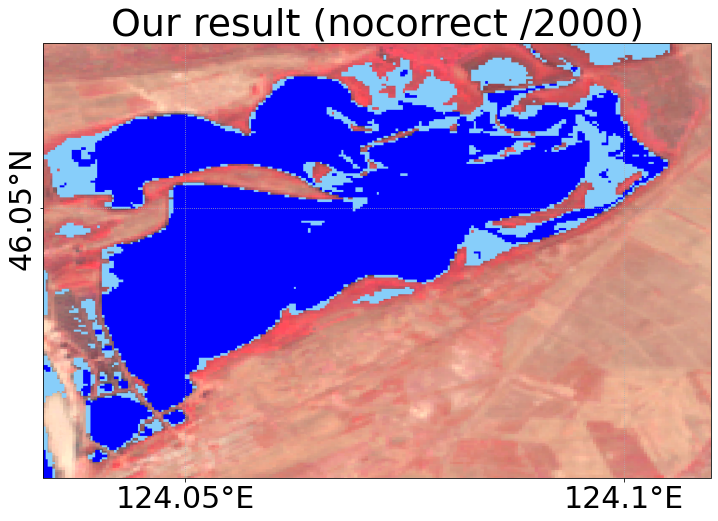

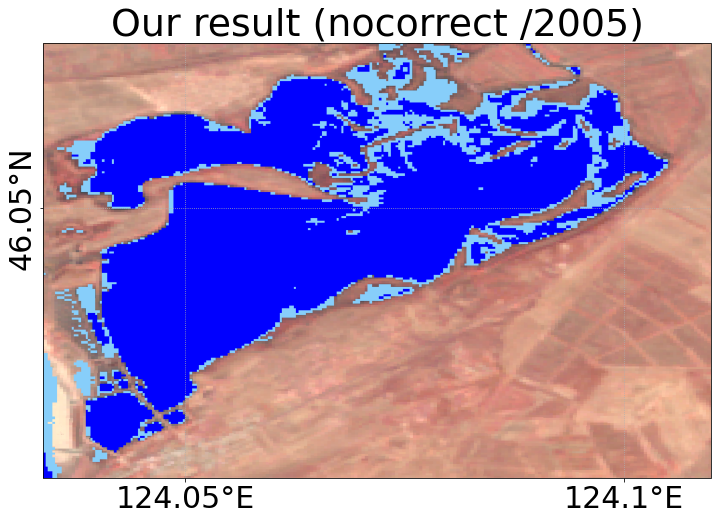

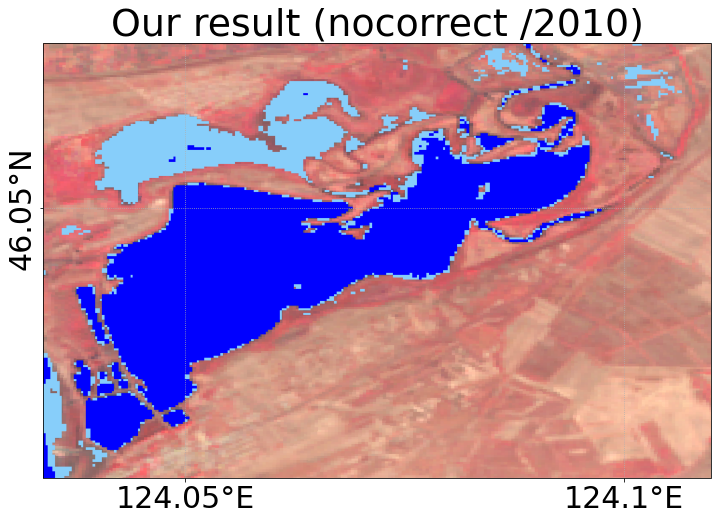

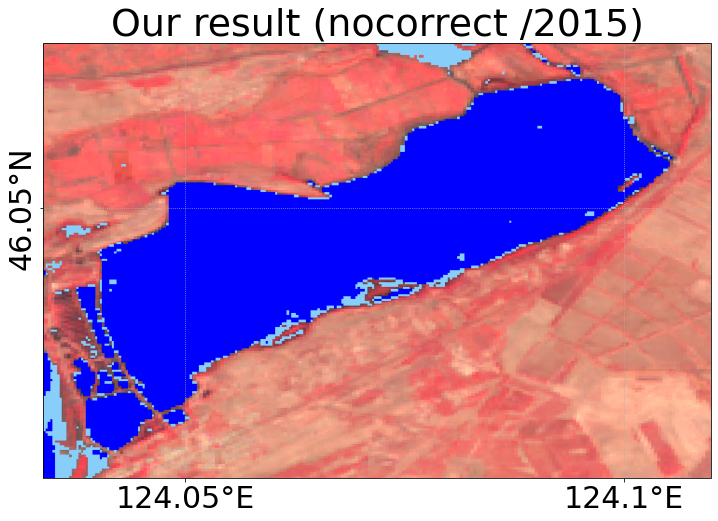

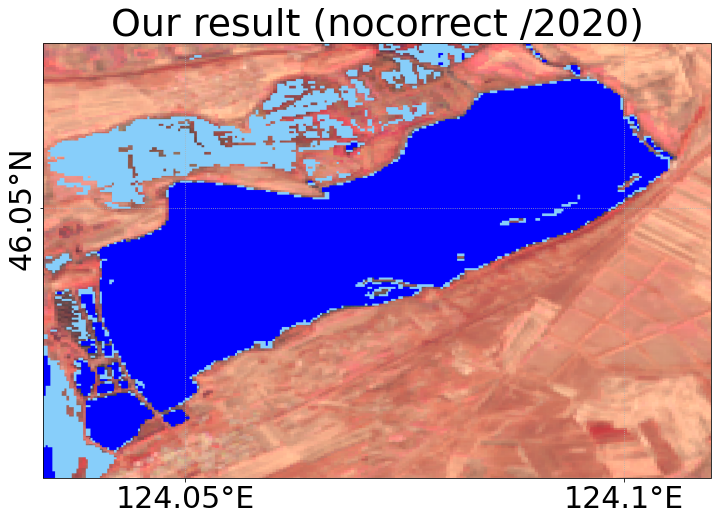

In [10]:
# 区域一
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# re = [124.0338, 46.0192, 124.1100, 46.0688]
re = [124.1100, 46.0192, 124.0338, 46.0688]

roi = ee.Geometry.Rectangle(re)
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)
l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

for year in range(2000,2021,5):
    startDate = str(year) + '-01-01'
    endDate = str(year) + '-12-31'
    refer_img = l58.filterDate(startDate, endDate).map(maskSR).median().clip(roi).visualize(**visParams)
    basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
    
    # JRC = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
    # pw = ee.ImageCollection([JRC,basemap]).sum()
    # label = 'GSWD ('+ str(year) + ")" 
    
    # result = ee.Image('users/311605001111/WF/' + region + '_WF_' + str(year)).rename('waterclass')
    # permanent = result.gte(0.75).remap([0,1],[0,2]).rename('waterclass')
    # season= ee.ImageCollection([result.gte(0.25),result.lt(0.75)]).sum().eq(2).rename('waterclass')
    # pw = ee.ImageCollection([permanent,season,basemap]).sum()
    # label = 'Our result ('+ str(year) + ")"
    
    result = ee.Image('users/311605001111/WF_nocorrect/' + region + '_WF_' + str(year)).rename('waterclass')
    permanent = result.gte(0.75).remap([0,1],[0,2]).rename('waterclass')
    season= ee.ImageCollection([result.gte(0.25),result.lt(0.75)]).sum().eq(2).rename('waterclass')
    pw = ee.ImageCollection([permanent,season,basemap]).sum()
    label = 'Our result (nocorrect /'+ str(year) + ")" 
    
    # Maryland = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).select('b1').rename('waterclass')
    # Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
    # Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
    # pw = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
    # label = 'GLAD ('+ str(year) + ")" 
    
    blend = refer_img.blend(pw.selfMask().visualize(**{'palette':['#87CEFA', 'blue'],'min':1,'max':2}))
    # blend = pw.selfMask().visualize(**{'palette':['blue']})
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=re)
    cartoee.add_gridlines(ax, interval=[0.05,0.05], linestyle=":", ytick_rotation="vertical")
    ax.tick_params(labelsize=30)
    # cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
    ax.set_title(label = label, fontsize=38)

## 区域一

In [ ]:
## 新
# 124.5340, 46.1914,124.6092, 46.2354

# 124.0246, 46.0173, 124.1115, 46.0662

In [ ]:
# 区域一
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
re = [124.5340, 46.1914,124.6092, 46.2354]
roi = ee.Geometry.Rectangle(re)
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filter(ee.Filter.lt('CLOUD_COVER',80))
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)
l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

for year in range(2000,2021,5):
    startDate = str(year) + '-01-01'
    endDate = str(year) + '-12-31'
    refer_img = l58.filterDate(startDate, endDate).map(maskSR).median().clip(roi).visualize(**visParams)
    # pw = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi)
    # label = 'GSWD ('+ str(year) + ")"    
    pw = ee.Image('users/311605001111/WF/' + region + '_WF_' + str(year)).gte(0.75)
    label = 'Our result ('+ str(year) + ")"    
    # pw = ee.Image('users/311605001111/WF_nocorrect/' + region + '_WF_' + str(year)).gte(0.75)
    # label = 'Our result (nocorrect /'+ str(year) + ")"    
    # pw = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).gte(75)
    # label = 'GLAD ('+ str(year) + ")" 
    
    blend = refer_img.blend(pw.selfMask().visualize(**{'palette':['blue']}))
    # blend = pw.selfMask().visualize(**{'palette':['blue']})
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=re)
    # cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
    # cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
    ax.set_title(label = label, fontsize=28)

##  区域二

In [ ]:
90.2126, 34.6579,90.7726, 34.9779

In [ ]:
# 区域二
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [90.2126, 34.6579,90.7726, 34.9779]
roi = ee.Geometry.Rectangle(region)
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filter(ee.Filter.lt('CLOUD_COVER',80))
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)
l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}



for year in range(2020,2021,5):
    startDate = str(year) + '-01-01'
    endDate = str(year) + '-12-31'
    refer_img = l58.filterDate(startDate, endDate).map(maskSR).median().clip(roi).visualize(**visParams)
    # pw = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi)
    pw = ee.Image('users/311605001111/WF/tibet_WF_' + str(year)).gte(0.75)
    # pw = ee.Image('users/311605001111/WF_nocorrect/tibet_WF_' + str(year)).gte(0.75)
    # pw = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).gte(75)
    blend = refer_img.blend(pw.selfMask().visualize(**{'palette':['blue']}))
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=region)
    cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
    # label = 'refer image(median composite image/2020)'
    # label = 'GSWD ('+ str(year) + ")"
    # label = 'GLAD ('+ str(year) + ")"
    label = 'Experimental result ('+ str(year) + ")"
    # label = 'Experimental result (nocorrect /'+ str(year) + ")"
    ax.set_title(label = label, fontsize=28)

##  区域三

In [ ]:
90.42, 35,90.71, 35.14

In [ ]:
# 区域二
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [90.42, 35,90.71, 35.14]
roi = ee.Geometry.Rectangle(region)
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filter(ee.Filter.lt('CLOUD_COVER',80))
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)
l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}



for year in range(2020,2021,5):
    startDate = str(year) + '-01-01'
    endDate = str(year) + '-12-31'
    refer_img = l58.filterDate(startDate, endDate).map(maskSR).median().clip(roi).visualize(**visParams)
    # pw = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi)
    pw = ee.Image('users/311605001111/WF/tibet_WF_' + str(year)).gte(0.75)
    # pw = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).gte(75)
    blend = refer_img.blend(pw.selfMask().visualize(**{'palette':['blue']}))
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=region)
    cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
    # label = 'GLAD ('+ str(year) + ")"
    label = 'Experimental result ('+ str(year) + ")"
    ax.set_title(label = label, fontsize=28)

# 对比，JRC vs Experimental result

## 计算

In [ ]:
region = 'tibet'
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

In [ ]:
year = 2020
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'

l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate) \
       .filter(ee.Filter.lt('CLOUD_COVER',40))
 
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filterDate(startDate, endDate) \
#        .filter(ee.Filter.lt('CLOUD_COVER',35))
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)

l58 = l8.merge(l5)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(l58.map(maskSR).median().clip(roi), visParams,'image mosaic')

# JRC = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi)
# Map.addLayer(JRC.selfMask(),{'palette':['red']},"JRC")

# result = ee.Image('users/311605001111/WF/tibetan_WF_' + str(year)).gte(0.75)
# Map.addLayer(result.selfMask(),{'palette':['blue']},"result")

# Maryland = ee.Image('users/311605001111/Maryland/Maryland_nationwide_' + str(year)).clip(roi).gte(75)
# Map.addLayer(Maryland.selfMask(),{'palette':['yellow']},"Maryland")

In [ ]:
year = 2020
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)
Map.addLayer(l8.map(maskSR).median().clip(roi), visParams,'image mosaic')

In [ ]:
year = 2020

# 计算 JRC与Experimental result 的差异
JRC = ee.Image('JRC/GSW1_3/YearlyHistory/' + str(year)).gte(3).clip(roi).multiply(-2)
result = ee.Image('users/311605001111/WF/tibet_WF_' + str(year)).gte(0.75)
change = result.subtract(JRC)
Map.addLayer(change.selfMask(),{'palette':['red','yellow','blue'],'min':1,'max':3},"change")

# 合成制图
refer_img = l8.map(maskSR).median().clip(roi).visualize(**visParams)
blend = refer_img.blend(change.selfMask().visualize(**{'palette':['red','yellow','blue'],'min':1,'max':3}))
Map.addLayer(blend, {}, "Blend")

##  mapping (Comparison in 2000)

In [ ]:
# region E
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

region = [89.8826, 34.6579,91.3626, 35.8279]
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'GSWD vs Experimental result (2000)', fontsize=28)

# part A in region E
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

region = [89.8947, 35.2045, 89.9441, 35.2539]
fig = plt.figure(figsize=(12, 8))
# ax = cartoee.get_map(blend, region=region)
ax = cartoee.get_map(refer_img, region=region)

# part B in region E
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [90.6022, 35.0407, 90.6773, 35.1025]
fig = plt.figure(figsize=(12, 8))
# ax = cartoee.get_map(blend, region=region)
ax = cartoee.get_map(refer_img, region=region)

# part C in region E
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [90.2668, 34.7454, 90.3332, 34.8093]
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
# ax = cartoee.get_map(refer_img, region=region)



# WP、VP in 2010

In [ ]:
vp_no = ee.Image('users/311605001111/WP-VP-nocorrect/daqing_VP_2010').clip(roi)
Map.addLayer(vp_no,{'palette':['white','green'],'min':0,'max':100}, 'vp_no')

wp_no = ee.Image('users/311605001111/WP-VP-nocorrect/daqing_WP_2010').clip(roi)
Map.addLayer(wp_no,{'palette':['white','purple'],'min':0,'max':100}, 'wp_no')

vp = ee.Image('users/311605001111/WP-VP/daqing_VP_2010').clip(roi)
Map.addLayer(vp,{'palette':['white','green'],'min':0,'max':100}, 'vp')

wp = ee.Image('users/311605001111/WP-VP/daqing_WP_2010').clip(roi)
Map.addLayer(wp,{'palette':['white','purple'],'min':0,'max':100}, 'wp')

waterfrequency = ee.Image("users/311605001111/WF/daqing_WF_2010")
Map.addLayer(waterfrequency,{'palette':['white','blue'],'min':0,'max':1}, 'water frequency')

In [ ]:
roi = ee.Geometry.Rectangle([124.0338, 46.0192, 124.1100, 46.0688])
## 大庆
minmax = vp_no.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
minmax = wp_no.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
minmax = vp.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
minmax = wp.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [124.0338, 46.0192, 124.1100, 46.0688] 
fig = plt.figure(figsize=(10, 6))
visParams = {'min': 0.0,'max': 35}

ax = cartoee.get_map(vp_no,cmap="rainbow",region=region,vis_params=visParams)
cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.03,0.03], linestyle=":")
ax.set_title(label = 'valid pixels (w/o correction)', fontsize=18)

In [ ]:
# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [124.0338, 46.0192, 124.1100, 46.0688] 
fig = plt.figure(figsize=(10, 6))
visParams = {'min': 0.0,'max': 35}

ax = cartoee.get_map(wp_no,cmap="rainbow",region=region,vis_params=visParams)
cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.03,0.03], linestyle=":")
ax.set_title(label = 'water pixels (w/o correction)', fontsize=18)

In [ ]:
# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [124.0338, 46.0192, 124.1100, 46.0688] 
fig = plt.figure(figsize=(10, 6))
visParams = {'min': 0.0,'max': 35}

ax = cartoee.get_map(vp,cmap="rainbow",region=region,vis_params=visParams)
cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.03,0.03], linestyle=":")
ax.set_title(label = 'valid pixels (with correction)', fontsize=18)

In [ ]:
# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [124.0338, 46.0192, 124.1100, 46.0688] 
fig = plt.figure(figsize=(10, 6))
visParams = {'min': 0.0,'max': 35}

ax = cartoee.get_map(wp,cmap="rainbow",region=region,vis_params=visParams)
cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.03,0.03], linestyle=":")
ax.set_title(label = 'water pixels (with correction)', fontsize=18)